In [1]:
import pandas as pd
import glob
import yaml
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import logging
import os

from utils_kk.tool_functions.data_transformer import read_directory_parquet, select_RDK_parameters, rename_RDK_parameters, \
                                   generate_extra_features, retrieve_serialnumber, get_baseline_statistics, \
                                   column_info

from typing import TypedDict, List
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
load_dotenv(override=True)


True

## 1. Get DATA in memory

In [2]:
data_dir = "knowledge_folder/datapoints/DE_router_data_all/"
config_fileloc = 'config/config.yaml'
serialnumber_selected = "90100000000V412000536"

router_data = read_directory_parquet(data_dir)
router_data = select_RDK_parameters(router_data, config_fileloc)
router_data = retrieve_serialnumber(router_data, serialnumber_selected)
router_data = rename_RDK_parameters(router_data)
router_data = generate_extra_features(router_data)

In [3]:
llm = AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_API_BASE"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("OPENAI_API_VERSION"),
    # max_tokens=500,
    temperature=0,
    deployment_name=os.getenv('AZURE_OPENAI_DEPLOYMENT_NAME'),
    model_name=os.getenv('AZURE_OPENAI_ASSISTANT_MODEL'),
)

In [1]:
from utils_kk.misl_function.misl_getData import get_data
from langgraph.graph import StateGraph, MessagesState
from langgraph.graph import START, END
from langgraph.checkpoint.memory import MemorySaver
from utils_kk.nodes.node_intentClassification import intent_classification_node
from utils_kk.variables.variable_definitions import customGraph
from utils_kk.nodes.node_chitchat import chit_chat_agent, validate_chit_chat, merge_answer
from utils_kk.nodes.node_rca import rca_agent
from utils_kk.branching.branch_control import intent_classification_branch, chit_chat_branch
from dotenv import load_dotenv

## 2. Create Agent State

In [1]:
from main import create_graph
flow = create_graph()

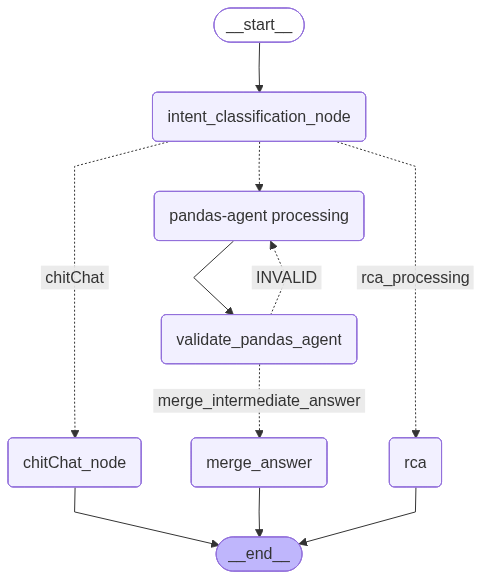

In [2]:
flow

In [4]:
from langgraph.graph import StateGraph, MessagesState
from langgraph.graph import START, END
from utils_kk.nodes.node_intentClassification import intent_classification_node
from utils_kk.variables.variable_definitions import customGraph
from utils_kk.nodes.node_chitchat import chit_chat_agent
from utils_kk.nodes.node_rca import rca_agent

In [5]:
def intent_classification_branch(state: customGraph):

    intent = state["intent_classification"]
    if intent == "rca":
        return "rca_processing"

    elif intent == "chit-chat":
        return "chit-chat processing"

In [2]:
def create_graph():
    graph = StateGraph(state_schema=customGraph)
    graph.add_node("intent_classification_node", intent_classification_node)
    graph.add_edge(START, "intent_classification_node")
    graph.add_conditional_edges("intent_classification_node", intent_classification_branch, 
                               {"rca_processing": "rca", "chit-chat processing": "chit-chat"})

    ## Flow-1
    graph.add_node("chit-chat", chit_chat_agent)
    graph.add_node("validate_chit_chat", validate_chit_chat)
    graph.add_node("merge_answer", merge_answer)
    graph.add_edge("chit-chat", "validate_chit_chat")
    graph.add_conditional_edges("validate_chit_chat", chit_chat_branch,
                                {"VALID": "merge_answer", "INVALID": "chit-chat"}
    )
    graph.add_edge("merge_answer", END)
    
    ## Flow-2
    graph.add_node("rca", rca_agent)
    graph.add_edge("rca", END)

    store = MemorySaver()
    flow = graph.compile()
    return flow

In [3]:
flow = create_graph()

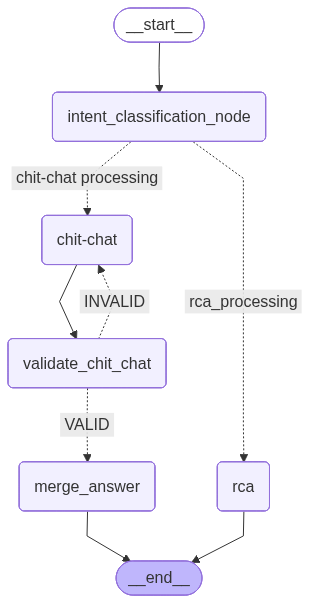

In [4]:
flow

In [9]:
flow = create_graph()

In [10]:
response = flow.invoke({
        "question": "What is the avergae CPU Usage for 90100000000V412000536?", 
        "data": router_data
    })

2025-09-30 21:56:29 [debug    ] -- From intent classification node detail='What is the avergae CPU Usage for 90100000000V412000536?'
2025-09-30 21:56:31 [debug    ] -- Intent classification node  detail={'intent': 'chit-chat'}
2025-09-30 21:56:31 [debug    ] -- From chitchat node          detail='What is the avergae CPU Usage for 90100000000V412000536?'


> Entering new AgentExecutor chain...


/Users/A118390615/Library/CloudStorage/OneDrive-DeutscheTelekomAG/Projects/bb_troubleshooter_chatbot/utils_kk/nodes/node_chitchat.py:25: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
/Users/A118390615/Library/CloudStorage/OneDrive-DeutscheTelekomAG/Projects/bb_troubleshooter_chatbot/.venv/lib/python3.13/site-packages/langchain_experimental/agents/agent_toolkits/pandas/base.py:283: UserWarning: Received additional kwargs {'memory': ConversationBufferMemory(chat_memory=InMemoryChatMessageHistory(messages=[]), return_messages=True, memory_key='chat_history')} which are no longer supported.
  warnings.warn(



Invoking: `python_repl_ast` with `{'query': "average_cpu_usage = df[df['serialnumber'] == '90100000000V412000536']['cpuusage'].mean()\naverage_cpu_usage"}`


23.118754707506906The average CPU usage for the serial number `90100000000V412000536` is approximately 23.12%.

> Finished chain.


In [ ]:
response['final_result']    

'The average CPU usage for the serial number `90100000000V412000536` is approximately 23.12%.'

In [22]:
graph_compiled = graph.compile()

In [23]:
graph_compiled.invoke({"question": "What was the root cause of the reboot at 2024-08-02 20:07:00?"})

2025-09-30 20:34:18 [debug    ] -- From intent classification node detail='What was the root cause of the reboot at 2024-08-02 20:07:00?'
2025-09-30 20:34:19 [debug    ] -- Intent classification node  detail={'intent': 'rca'}
2 validation errors for AIMessage
content.str
  Input should be a valid string [type=string_type, input_value={'intent': 'rca'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]]
  Input should be a valid list [type=list_type, input_value={'intent': 'rca'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/list_type


IndexError: list index out of range

In [10]:
def intent_classification_node(state: customGraph):

    if state.get("bypass_intention", None):
        structlogger.error("ByPassing intent classification")
        return {"generation_scratchpad": [AIMessage(content=response)]}

    else:
        query = state.get("question", None)
        structlogger.debug("-- From intent classification node", detail=query)
        output_format = PydanticOutputParser(
            pydantic_object = IntentClassification).get_format_instructions()
        intent_classification_prompt = PromptTemplate(template=intent_classification_template,
                                                      partial_variables={
            "output_parser": output_format                                                                     
        })
        chain = intent_classification_prompt | llm | JsonOutputParser()

        try:
            for trial in range(int(os.getenv("num_retries", None))):
                response = chain.invoke(input={"user_query": query})
                if isinstance(response, dict):
                    if "intent" in response:
                        state["intent_classification"] = response["intent"]
                        structlogger.debug("-- Intent classification node", detail=response)
                        return {"generation_scratchpad": [AIMessage(content=json.dumps(response))]}
                        
                else:
                    structlogger.error("Wrong schema recieved", detail=response)
        except Exception as e:
            print(e)

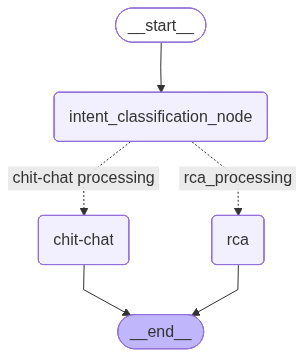

In [40]:
graph_compiled

In [23]:
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain.memory.buffer import ConversationBufferMemory

In [33]:
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
agent = create_pandas_dataframe_agent(llm, 
                                      router_data, 
                                      verbose=True, 
                                      agent_type="openai-tools", 
                                      allow_dangerous_code=True,
                                      memory=memory)

/Users/A118390615/Library/CloudStorage/OneDrive-DeutscheTelekomAG/Projects/bb_troubleshooter_chatbot/.venv/lib/python3.13/site-packages/langchain_experimental/agents/agent_toolkits/pandas/base.py:283: UserWarning: Received additional kwargs {'memory': ConversationBufferMemory(chat_memory=InMemoryChatMessageHistory(messages=[]), return_messages=True, memory_key='chat_history')} which are no longer supported.
  warnings.warn(


In [31]:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent, tools=[], memory=ConversationBufferMemory())

In [34]:
result = agent.invoke("What is the average CPU Usage for 90100000000V412000536?")



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "average_cpu_usage = df[df['serialnumber'] == '90100000000V412000536']['cpuusage'].mean()\naverage_cpu_usage"}`


23.118754707506906The average CPU usage for the serial number `90100000000V412000536` is approximately 23.12%.

> Finished chain.


In [22]:
result

{'input': 'What is the average CPU Usage for 90100000000V412000536?',
 'output': 'The average CPU usage for the serial number `90100000000V412000536` is approximately 23.12%.'}

,serialnumber,date,time,productclass,manufacturer,hardware_version,firmware_version,telemetry_restart,wifi_accesspoint_1_status,wifi_accesspoint_2_status,...,downlink_rate_min,downlink_rate_max,downlink_rate_avg,uplink_rate_min,uplink_rate_max,uplink_rate_avg,total_band_change,timestamp,wifi_radio_1_total_channels_active,wifi_radio_2_total_channels_active
254439,90100000000V412000536,2025-09-23,2025-09-23 23:59:13,DT-HGW01A-ARC,Arcadyan,01,004.011.078,0,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-23 23:59:13,1,8
361071,90100000000V412000536,2025-09-23,2025-09-23 23:44:05,DT-HGW01A-ARC,Arcadyan,01,004.011.078,0,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-23 23:44:05,1,8
53601,90100000000V412000536,2025-09-23,2025-09-23 23:28:56,DT-HGW01A-ARC,Arcadyan,01,004.011.078,0,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-23 23:28:56,1,8
316678,90100000000V412000536,2025-09-23,2025-09-23 23:13:45,DT-HGW01A-ARC,Arcadyan,01,004.011.078,0,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-23 23:13:45,1,8
98051,90100000000V412000536,2025-09-23,2025-09-23 22:58:37,DT-HGW01A-ARC,Arcadyan,01,004.011.078,0,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-23 22:58:37,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218248,90100000000V412000536,2025-03-29,2025-03-29 18:04:19,DT-HGW01A-ARC,Arcadyan,01,004.011.052,0,Enabled,Enabled,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-29 18:04:19,1,8
44257,90100000000V412000536,2025-03-29,2025-03-29 17:49:19,DT-HGW01A-ARC,Arcadyan,01,004.011.052,0,Enabled,Enabled,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-29 17:49:19,1,8
70925,90100000000V412000536,2025-03-29,2025-03-29 17:34:19,DT-HGW01A-ARC,Arcadyan,01,004.011.052,0,Enabled,Enabled,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-29 17:34:19,1,8
62069,90100000000V412000536,2025-03-29,2025-03-29 17:19:19,DT-HGW01A-ARC,Arcadyan,01,004.011.052,0,Enabled,Enabled,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-29 17:19:19,1,8


In [48]:
router_data

,serialnumber,date,time,productclass,manufacturer,hardwareversion,version,last_reboot_reason_split,telemetry_restart,wifi_accesspoint_1_status,...,max_signalstrength,avg_signalstrength,min_lastdatadownlinkrate,max_lastdatadownlinkrate,avg_lastdatadownlinkrate,min_lastdatauplinkrate,max_lastdatauplinkrate,avg_lastdatauplinkrate,n_devices,total_band_change
0,90100000000V412000536,2025-03-30,2025-03-30 11:12:51,DT-HGW01A-ARC,Arcadyan,01,004.011.052,unknown,None,Enabled,...,-52.0,-62.833333,6.0,1921.0,569.166667,1.0,1152.0,478.000000,6.0,0.0
1,90100000000V412000536,2025-03-31,2025-03-31 04:43:23,DT-HGW01A-ARC,Arcadyan,01,004.011.052,unknown,None,Enabled,...,-53.0,-65.000000,11.0,1297.0,406.600000,6.0,1152.0,376.600000,5.0,0.0
2,90100000000V412000536,2025-03-31,2025-03-31 14:28:23,DT-HGW01A-ARC,Arcadyan,01,004.011.052,unknown,None,Enabled,...,-53.0,-62.000000,65.0,390.0,251.666667,52.0,433.0,211.666667,3.0,0.0
3,90100000000V412000536,2025-04-01,2025-04-01 06:28:12,DT-HGW01A-ARC,Arcadyan,01,004.011.052,unknown,None,Enabled,...,-52.0,-64.500000,65.0,2161.0,721.500000,26.0,1729.0,549.250000,4.0,0.0
4,90100000000V412000536,2025-04-01,2025-04-01 20:43:13,DT-HGW01A-ARC,Arcadyan,01,004.011.052,unknown,None,Enabled,...,-52.0,-66.750000,6.0,1297.0,439.500000,26.0,864.0,536.000000,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369397,901A0000000V503014579,2025-09-16,2025-09-16 00:03:01,DT-HGW01A-ARC,Arcadyan,03,004.011.078,powerloss-reboot,None,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369398,901A0000000V503014579,2025-09-17,2025-09-17 08:29:06,DT-HGW01A-ARC,Arcadyan,03,004.011.078,powerloss-reboot,None,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369399,901A0000000V503014579,2025-09-17,2025-09-17 17:46:36,DT-HGW01A-ARC,Arcadyan,03,004.011.078,powerloss-reboot,None,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369400,901A0000000V503014579,2025-09-18,2025-09-18 09:45:52,DT-HGW01A-ARC,Arcadyan,03,004.011.078,powerloss-reboot,None,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
for file_name in glob.glob('datapoints/DE_router_data/DE_baseline_router_data/*.parquet'):
    print(file_name)

'../datapoints/DE_router_data/DE_baseline_router_data/'